# BoltzRank #
## Luca Negrini - Mat. 956516 ##
### From "BoltzRank: Learning to Maximize Expected Ranking Gain" ###
#### Maxims M. Volkovs, Richard S. Zemel ####

------
#### Initialization ####

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%matplotlib notebook

%load_ext cython

# install lightgbm (required only on first run)
# import sys
# !{sys.executable} -m pip install lightgbm

import os
import os.path
import numpy as np
import lightgbm
import matplotlib.pyplot as plt

# see http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html
from sklearn.datasets import load_svmlight_file 

# datasets available at: 
# https://www.microsoft.com/en-us/research/project/mslr/
DATASET_FOLDER = "C:/opt/kiis-training/MSLR-WEB10K/Fold1/"
PERM_FOLDER = DATASET_FOLDER + "perms/"
METRIC_NAME = 'ndcg@10'#'BoltzRank-NDCG@10'

-----
#### Data loading ####

In [2]:
def ensureFile(path):
    if not os.path.exists(path) or not os.path.isfile(path):
        raise FileNotFoundError("'" + path + "': no such file")        
    return path

def retrieveFileNames():
    folder = DATASET_FOLDER + '/' if DATASET_FOLDER[-1:] != '/' else DATASET_FOLDER
    train_file = ensureFile(folder + "train.txt")
    valid_file = ensureFile(folder + "vali.txt")
    test_file = ensureFile(folder + "test.txt")
    return train_file, valid_file, test_file

def loadDataset(path):
    return load_svmlight_file(path, query_id=True)

def loadLightGBM(svmlight_dataset):
    query_lens = [sum(1 for _ in group) for key, group in itertools.groupby(svmlight_dataset[2])]
    return lightgbm.Dataset(data=svmlight_dataset[0], label=svmlight_dataset[1], group=query_lens)

In [3]:
class Query:
    def __init__(self, qid):
        self.qid = qid
        self.labels_to_docs = {}
    def addlabel(self, label):
        if not label in self.labels_to_docs:
            self.labels_to_docs[label] = list()
    def adddoc(self, label, doc):
        self.labels_to_docs[label].append(doc)
    def finalize(self, alllabels):
        self.labels = np.zeros(len(self.labels_to_docs.keys()), dtype=int)
        self.docs = np.empty(len(self.labels_to_docs.keys()), dtype=object)
        i = 0
        totaldocs = 0
        sorteddict = sorted(self.labels_to_docs.items(), reverse = True)
        for label, docs in sorteddict:
            self.labels[i] = label
            self.docs[i] = np.zeros(len(docs), dtype=int)
            for j in range(len(docs)):
                self.docs[i][j] = docs[j]
            i += 1
            totaldocs += len(docs)
        self.alldocs = np.concatenate(self.docs)
        self.flatlabels = np.zeros(totaldocs, dtype=np.double)
        i = 0
        for label, docs in sorteddict:
            for j in range(len(docs)):
                self.flatlabels[i] = label
                i += 1       
        k = min(10, len(self.alldocs))
        self.idealdcg = dcg_k(self.alldocs, alllabels, k) 
        del self.labels_to_docs
    def setperms(self, perms):
        self.perms = perms
    def setndcgs(self, ndcgs):
        self.ndcgs = ndcgs
    def __repr__(self):  
        return str(self)
    def __str__(self):
        res = "Query " + str(self.qid) + "["
        res += "\nideal dcg: " + str(self.idealdcg)
        for i in range(len(self.labels)):
            res += "\n" + str(self.labels[i]) + " -> " + str(self.docs[i])
        res += "]"
        if hasattr(self, 'perms'):
            for i in range(len(self.perms)):
                res += "\n[" + str(self.perms[i]) + "] -> dcg: " + str(self.ndcgs[i])
        else:
            res += "\nNo permutations computed yet"
        return res

In [4]:
# parameters:
#  dataset: svmlight_dataset 
#      the datset to process
# returned values:
#  query_to_labels_to_documents: dict(int -> dict(float -> list(int)))
#      a map containing, for each query in the dataset, the documents (row index in the dataset) provided 
#      in the input dataset grouped by label
#  doc_to_query: dict(document -> query)
#      a mapping between document (row index in the dataset) and the relative query
def mapQueryToDocuments(dataset):
    queries = {}
    alllabels = np.negative(np.ones(len(dataset[2]), dtype=np.double))
    for i in range(0, len(dataset[2])):
        if not dataset[2][i] in queries:
            queries[dataset[2][i]] = Query(dataset[2][i])
        query = queries[dataset[2][i]]
        query.addlabel(dataset[1][i])
        query.adddoc(dataset[1][i], i)
        alllabels[i] = dataset[1][i]
        
    for q in queries.values():
        q.finalize(alllabels)
    
    return queries, alllabels

-----
#### Rank sample set generation ####

In [5]:
%%cython 
from libc.math cimport exp
from cython.parallel import prange
from cython import boundscheck, wraparound, cdivision
from libc.math cimport log2
from math import factorial
import numpy as np
import random
import itertools
from libc.stdio cimport printf
from libc.stdlib cimport malloc
from libc.stdlib cimport free

@boundscheck(False)
@wraparound(False)
cdef double* E(int[:] R, double[:] S) nogil:
    cdef int k, j, m = len(R)
    cdef double* energy = <double *> malloc(m*sizeof(double))
    cdef double res_w_S, factor 
    if m == 1 or m == 0:
        for j in prange(len(R), schedule='static', num_threads=8):
            energy[j] = 0
    else:
        factor = 4.0 / (m * ((m - 1)**2))
        for j in prange(len(R), schedule='static', num_threads=8):
            res_w_S = 0.0
            for k in range(len(R)):
                if k < j: 
                    res_w_S = res_w_S + (j - k) * (S[R[j]] - S[R[k]])
                elif k > j: 
                    res_w_S = res_w_S + (k - j) * (S[R[k]] - S[R[j]])
            energy[j] = factor * res_w_S
    return energy

@boundscheck(False)
@wraparound(False)
cdef void P(int[:,:] Rq, double[:] S, double[:,:] probs, double[:] accumulator) nogil:
    cdef int rankid, pos, doc
    cdef double* en
    for rankid in prange(len(Rq), schedule='static', num_threads=8):
        en = E(Rq[rankid], S)
        for pos in range(len(Rq[rankid])):
            doc = Rq[rankid][pos]
            probs[doc][rankid] = exp(-en[pos]) # e^{-E}
            accumulator[doc] = accumulator[doc] + probs[doc][rankid] # sum(e^{-E})
        free(en)
    for pos in prange(len(Rq[0]), schedule='static', num_threads=8):
        doc = Rq[0][pos]
        # e^{-E} / sum(e^{-E})
        probs[doc][rankid] = probs[doc][rankid] / accumulator[doc]
        
###############################################################################################################
###############################################################################################################
#                                              NDCG EVALUATION
###############################################################################################################
###############################################################################################################

@boundscheck(False)
@wraparound(False)
cpdef double dcg_k(int[:] rank, double[:] scores, int k) nogil:
    cdef double result = 0
    cdef int i
    for i in prange(k, schedule='static', num_threads=8):
        result += (2**scores[rank[i]] - 1) / (log2(i + 2)) # should be i+1, but with numbering starting from 1 instead of 0
    return result


@boundscheck(False)
@wraparound(False)
cdef double ndcg_k(int[:] rank, double[:] scores, int k, double ideal) nogil:
    if ideal == 0:
        return 1.0
    return dcg_k(rank, scores, k) / ideal

###############################################################################################################
###############################################################################################################
#                                          PERMUTATIONS GENERATION
###############################################################################################################
###############################################################################################################

RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS = 100
RANK_SAMPLE_SET_DISTRIBUTIONS = [
                                int(.30 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->0
                                int(.22 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->1
                                int(.18 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->2
                                int(.12 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->3
                                int(.10 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 3->0
                                int(.06 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 3->1
                                int(.02 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 3->2
                                int(.0 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 2->0
                                int(.0 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 2->1
                                int(.0 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS)  # 1->0
                                ]

@boundscheck(False)
@wraparound(False)
cdef bint contained(int[:,:] container, int[:] array) nogil:
    cdef bint match
    cdef int i
    cdef int j
    for i in prange(len(container), schedule='static', num_threads=8):
        if container[i][0] == -1 or len(container[i]) != len(array):
            continue
        else:
            match = True
            for j in range(len(container[i])):
                if container[i][j] != array[j]:
                    match = False
                    break
            if match:
                return True
    return False

@boundscheck(False)
@wraparound(False)
cdef void setrow(int[:,:] container, int pos, int[:] array) nogil:
    cdef int i
    for i in prange(len(container[pos]), schedule='static', num_threads=8):
        container[pos][i] = array[i]

@boundscheck(False)
@wraparound(False)
cdef int[:,:] allPerms(int[:] source, long long fact):
    cdef int i = 0
    cdef int k
    perm = itertools.permutations(source)
    cdef int[:,:] result = np.zeros((fact, len(source)), dtype=int)
    for p in perm:
        for k in range(len(p)):
            result[i][k] = p[k]
        i += 1
    return result

#source: label -> docid*, i: int, j: int, count: int, perms_with_prob: tuple<int> -> float
#return: number of not computed permutations
@boundscheck(False)
@wraparound(False)
def perform_permutation(query, int i, int j, int count, int[:,:] perms, int start):
    if not i in query.labels or not j in query.labels:
        # no swapping possible
        return count, start
    # find the indexes of the desired labels
    i = [k for k in range(len(query.labels)) if query.labels[k] == i][0]
    j = [k for k in range(len(query.labels)) if query.labels[k] == j][0]
    cdef int c = 0
    cdef int _min = min(len(query.docs[i]), len(query.docs[j]))
    cdef int amount = max(1, int(_min * .5))
    limit = factorial(_min) / (factorial(amount) * factorial(_min - amount))
    cdef int k
    cdef int d
    for k in range(count):
        perm = query.docs.copy()
        first = random.sample(range(len(query.docs[i])), k=amount)
        second = random.sample(range(len(query.docs[j])), k=amount)
        for d in range(len(first)):
            perm[i][first[d]], perm[j][second[d]] = query.docs[j][second[d]], query.docs[i][first[d]]
        p = np.concatenate(perm)
        if not contained(perms, p):
            setrow(perms, start + c, p)
            c += 1
            if c == limit:
                return count - c, start + c
        else:
            k -= 1
    return 0, start + c

@boundscheck(False)
@wraparound(False)
def process_query(query, alllabels, probs, accumulator):
    cdef int carry = 0
    fact = factorial(len(query.alldocs))
    cdef perms
    cdef int last = 0
    if fact <= RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS:
        # evaluate all possible permutations, each one representing a different ranking
        perms = allPerms(query.alldocs, fact)
    else:
        perms = np.negative(np.ones((RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS, len(query.alldocs)), dtype=int))
        # switch the labels of the documents, then sort the documents by label to obtain a ranking
        carry, last = perform_permutation(query, 4, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[0], perms, last)
        carry, last = perform_permutation(query, 4, 1, RANK_SAMPLE_SET_DISTRIBUTIONS[1] + carry, perms, last)
        carry, last = perform_permutation(query, 4, 2, RANK_SAMPLE_SET_DISTRIBUTIONS[2] + carry, perms, last)
        carry, last = perform_permutation(query, 4, 3, RANK_SAMPLE_SET_DISTRIBUTIONS[3] + carry, perms, last)
        carry, last = perform_permutation(query, 3, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[4] + carry, perms, last)
        carry, last = perform_permutation(query, 3, 1, RANK_SAMPLE_SET_DISTRIBUTIONS[5] + carry, perms, last)
        carry, last = perform_permutation(query, 3, 2, RANK_SAMPLE_SET_DISTRIBUTIONS[6] + carry, perms, last)
        carry, last = perform_permutation(query, 2, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[7] + carry, perms, last)
        carry, last = perform_permutation(query, 2, 1, RANK_SAMPLE_SET_DISTRIBUTIONS[8] + carry, perms, last)
        carry, last = perform_permutation(query, 1, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[9] + carry, perms, last)
        if carry != 0:
            if not query.alldocs in perms:
                perms[last] = query.alldocs
        perms = perms[perms.max(axis=1)>=0]
    query.setperms(perms)  
    P(perms, alllabels, probs, accumulator)
    cdef double[:] ndcgs = np.zeros(len(perms))
    cdef int k = min(10, len(perms[0]))
    for i in range(len(perms)):
        ndcgs[i] = ndcg_k(perms[i], alllabels, k, query.idealdcg)
    query.setndcgs(ndcgs)
    return query

In [6]:
train_file, valid_file, test_file = retrieveFileNames()

print("training file: " + train_file)
print("validation file: " + valid_file)
print("test file: " + test_file)
    
print("loading datasets... ")
import time
start = time.process_time()
train_dataset = loadDataset(train_file)
print("train dataset loading took " + str(time.process_time() - start) + " s")
start = time.process_time()
valid_dataset = loadDataset(valid_file)
print("validation dataset loading took " + str(time.process_time() - start) + " s")
start = time.process_time()
test_dataset = loadDataset(test_file)
print("test dataset loading took " + str(time.process_time() - start) + " s")

import itertools
print("converting datasets to LightGBM format... ")
train_lgb = loadLightGBM(train_dataset)
valid_lgb = loadLightGBM(valid_dataset)
test_lgb = loadLightGBM(test_dataset)

print("done")

training file: C:/opt/kiis-training/MSLR-WEB10K/Fold1/train.txt
validation file: C:/opt/kiis-training/MSLR-WEB10K/Fold1/vali.txt
test file: C:/opt/kiis-training/MSLR-WEB10K/Fold1/test.txt
loading datasets... 
train dataset loading took 49.578125 s
validation dataset loading took 15.390625 s
test dataset loading took 15.53125 s
converting datasets to LightGBM format... 
done


In [7]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

print("creating query-documents mappings...")
train_id = file_len(train_file)
vali_id = file_len(valid_file)
test_id = file_len(test_file)
ds_to_queries = {}
ds_to_queries[train_id] = mapQueryToDocuments(train_dataset)
ds_to_queries[vali_id] = mapQueryToDocuments(valid_dataset)
ds_to_queries[test_id] = mapQueryToDocuments(test_dataset)
print("done")

creating query-documents mappings...
done


In [8]:
print("creating sample sets...")
start = time.process_time()

probs_with_labels = {}
RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS = 100
for ds_id, queries in ds_to_queries.items():
    probs_with_labels[ds_id] = np.zeros((len(queries[1]), RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS))
    accumulator = np.zeros(len(queries[1]))
    for q in queries[0].values():
        process_query(q, queries[1], probs_with_labels[ds_id], accumulator)    
    del accumulator
    
print("sample set creation took " + str(time.process_time() - start) + " s")
print("done")

creating sample sets...
sample set creation took 77.0625 s
done


--------
#### BoltzRank logic ####

In [9]:
%%cython 
from libc.math cimport exp
from cython.parallel import prange
from cython import boundscheck, wraparound, cdivision
from libc.math cimport log
from math import factorial
import numpy as np
cimport numpy as np
from libc.stdio cimport printf
from libc.stdlib cimport malloc
from libc.stdlib cimport free

# Energy function.
# params: 
#  R      the ranking to evaluate. Element i contains the id of the document in position i
#  S      the scoring vector. Element i contains the score of the document with id i
# returns:
#  a c matrix of size (m,2). Row i contains (energy, energy') w.r.t. document i
#  NB: call free on the returned matrix.
@boundscheck(False)
@wraparound(False)
cdef double** E(int[:] R, double[:] S) nogil:
    cdef int k, j, m = len(R)
    cdef double** energy = <double **> malloc(m*sizeof(double*)) # freed at 78
    cdef double res, res_w_S, factor
    if m == 1 or m == 0:
        for j in prange(len(R), schedule='static', num_threads=8):
            energy[j] = <double *> malloc(2*sizeof(double)) # freed at 77
            energy[j][0] = 0
            energy[j][1] = 0
    else:
        factor = 4.0 / (m * ((m - 1)**2))
        for j in prange(len(R), schedule='static', num_threads=8):
            energy[j] = <double *> malloc(2*sizeof(double)) # freed at 77
            res = 0.0
            res_w_S = 0.0
            for k in range(len(R)):
                if k < j: 
                    res = res + (j - k)
                    res_w_S = res_w_S + (j - k) * (S[R[j]] - S[R[k]])
                elif k > j: 
                    res = res + (k - j)
                    res_w_S = res_w_S + (k - j) * (S[R[k]] - S[R[j]])
            energy[j][0] = factor * res_w_S
            energy[j][1] = factor * res
    return energy

# Probability function.
# params: 
#  Rq    the rank sample set. Element i contains the i-th ranking, that is, an array of document ids
#  S     the scoring vector. Element i contains the score of the document with id i
#  probs a c matrix of size (len(S),len(Rq),3). Each row i contains the result of the computation w.r.t. document i. Each row contains a 
#        matrix (len(Rq),3) containing, for each ranking, a tuple (probability, probability', probability'')
@boundscheck(False)
@wraparound(False)
cdef void P(int[:,:] Rq, double[:] S, double*** probs, double** accumulator) nogil:
    cdef int rankid, pos, doc
    cdef double** en
    
    for pos in range(len(Rq[0])):
        doc = Rq[0][pos]
        probs[doc] = <double **> malloc(len(Rq)*sizeof(double*)) # freed at 139
        accumulator[doc] = <double *> malloc(3*sizeof(double*)) # freed at 92
        accumulator[doc][0] = 0
        accumulator[doc][1] = 0
        accumulator[doc][2] = 0
        for rankid in prange(len(Rq), schedule='static', num_threads=8):
            probs[doc][rankid] = <double *> malloc(3*sizeof(double)) # freed at 138
    
    for rankid in prange(len(Rq), schedule='static', num_threads=8):
        en = E(Rq[rankid], S)
        for pos in range(len(Rq[rankid])):
            doc = Rq[rankid][pos]
            probs[doc][rankid][0] = exp(-en[pos][0]) # e^{-E}
            probs[doc][rankid][1] = 0
            probs[doc][rankid][2] = en[pos][1] # E'
            accumulator[doc][0] = accumulator[doc][0] + probs[doc][rankid][0] # sum(e^{-E})
            accumulator[doc][1] = accumulator[doc][1] + (-en[pos][1] * probs[doc][rankid][0]) # sum(-E' * e^{-E})
            accumulator[doc][2] = accumulator[doc][2] + ((en[pos][1]**2) * probs[doc][rankid][0]) # sum(E'^2 * e^{-E})
            free(en[pos]) # allocated at 28
        free(en) # allocated at 24

    for pos in prange(len(Rq[0]), schedule='static', num_threads=8):
        doc = Rq[0][pos]
        # e^{-E} / sum(e^{-E})
        probs[doc][rankid][0] = probs[doc][rankid][0] / accumulator[doc][0]
        
        # -P * (E' + (sum(-E' * e^{-E}) / sum(e^{-E})))
        probs[doc][rankid][1] = -probs[doc][rankid][0] * (probs[doc][rankid][2] + (accumulator[doc][1] / accumulator[doc][0]))
                
        # -P' * (E' + (sum(-E' * e^{-E}) / sum(e^{-E}))) - P * (1 + (sum(E'^2 * e^{-E}) / sum(-E' * e^{-E})) - (sum(-E' * e^{-E})^2 / sum(e^{-E})^2))
        probs[doc][rankid][2] = (-probs[doc][rankid][1] * (probs[doc][rankid][2] + (accumulator[doc][1] / accumulator[doc][0]))) 
        probs[doc][rankid][2] = probs[doc][rankid][2] - (probs[doc][rankid][0] * (1 + ((accumulator[doc][2] / accumulator[doc][0]) - (accumulator[doc][1]**2 / accumulator[doc][0]**2))))
        
        free(accumulator[doc]) # allocated at 63
        
        if isnan(probs[doc][rankid][0]):
            printf("prob of document %d in rank %d is nan\n", doc, rankid)
            with gil:
                raise TypeError("foo")
        if isnan(probs[doc][rankid][1]):
            printf("prob' of document %d in rank %d is nan\n", doc, rankid)
            with gil:
                raise TypeError("foo")
        if isnan(probs[doc][rankid][2]):
            printf("prob'' of document %d in rank %d is nan\n", doc, rankid)
            with gil:
                raise TypeError("foo")
        
# Gain function.
# params: 
#  Rq                the rank sample set. Element i contains the i-th ranking, that is, an array of document ids
#  probs             a c matrix of size (len(S),len(Rq),3). Each row i contains the result of the computation w.r.t. document i. Each row contains a 
#                    matrix (len(Rq),3) containing, for each ranking, a tuple (probability, probability', probability'')
#  probs_with_labels a c matrix of size (len(S),len(Rq)). Each row i contains the result of the computation w.r.t. document i. Each row contains an 
#                    array (len(Rq)) containing, for each ranking, its probability w.r.t. the target labeling
#  gains             a c matrix of size (len(S),3) containing, for each document, the evaluated gain with its two derivatives. 
@boundscheck(False)
@wraparound(False)
cdef void monte_carlo_gain(int[:,:] Rq, double*** probs, double[:] ndcgs, double** gains) nogil:
    cdef int i, doc, j
    for i in prange(len(Rq[0]), schedule='static', num_threads=8):
        doc = Rq[0][i]
        gains[doc] = <double*> malloc(3*sizeof(double)) # freed at 163
        gains[doc][0] = 0
        gains[doc][1] = 0
        gains[doc][2] = 0
        for j in range(len(Rq)):
            gains[doc][0] = gains[doc][0] + probs[doc][j][0] * ndcgs[j]
            gains[doc][1] = gains[doc][1] + probs[doc][j][1] * ndcgs[j]
            gains[doc][2] = gains[doc][2] + probs[doc][j][2] * ndcgs[j]
        
# Cross entropy function.
# params: 
#  Rq                the rank sample set. Element i contains the i-th ranking, that is, an array of document ids
#  probs             a c matrix of size (len(S),len(Rq),3). Each row i contains the result of the computation w.r.t. document i. Each row contains a 
#                    matrix (len(Rq),3) containing, for each ranking, a tuple (probability, probability', probability'')
#  probs_with_labels a c matrix of size (len(S),len(Rq)). Each row i contains the result of the computation w.r.t. document i. Each row contains an 
#                    array (len(Rq)) containing, for each ranking, its probability w.r.t. the target labeling
#  entropies         a c matrix of size (len(S),3) containing, for each document, the evaluated cross entropy with its two derivatives. 
#                    NB the entropy's sign has not yet being flipped 
@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void cross_entropy(int[:,:] Rq, double*** probs, double[:,:] probs_with_labels, double** entropies) nogil:
    cdef int i, doc, j
    for i in prange(len(Rq[0]), schedule='static', num_threads=8):
        doc = Rq[0][i]
        entropies[doc] = <double*> malloc(3*sizeof(double)) # freed at 164
        entropies[doc][0] = 0
        entropies[doc][1] = 0
        entropies[doc][2] = 0
        for j in range(len(Rq)):
            # P(L)log(P(S))
            entropies[doc][0] = entropies[doc][0] + probs_with_labels[doc][j] * log(probs[doc][j][0])
            # P(L)(P'(S)/P(S))
            entropies[doc][1] = entropies[doc][1] + (probs_with_labels[doc][j] * probs[doc][j][1] / probs[doc][j][0])
            # P(L)(P(S)P''(S)-P'(S)^2)/P(S)^2
            entropies[doc][2] = entropies[doc][2] + (probs_with_labels[doc][j] * ((probs[doc][j][0] * probs[doc][j][2] - probs[doc][j][1]**2) / probs[doc][j][0]**2))
            
            if isnan(entropies[doc][0]):
                printf("entropies of document %d is nan after rank %d (probs %f)\n", doc, j, probs[doc][j][0])
                with gil:
                    raise TypeError("foo")
            if isnan(entropies[doc][1]):
                printf("entropies' of document %d is nan after rank %d (probs %f)\n", doc, j, probs[doc][j][0])
                with gil:
                    raise TypeError("foo")
            if isnan(entropies[doc][2]):
                printf("entropies'' of document %d is nan after rank %d (probs %f)\n", doc, j, probs[doc][j][0])
                printf("PL %f P %f P' %f P'' %f P*P''-P'^2 %f P^2%f\n", probs_with_labels[doc][j], probs[doc][j][0], probs[doc][j][1], probs[doc][j][2], probs[doc][j][0] * probs[doc][j][2] - probs[doc][j][1]**2, probs[doc][j][0]**2)
                with gil:
                    raise TypeError("foo")
                    
            free(probs[doc][j]) # allocated at 65

        free(probs[doc]) # allocated at 62
    
from libc.math cimport isnan

# Boltzrank grads and hess evaluation function.
@boundscheck(False)
@wraparound(False)
def eval_boltzrank_grads(queries, S, probs_with_labels): 
    cdef double lam = .9
    cdef double[:] gain = np.ones_like(S)
    cdef double[:] hess = np.ones_like(S) 
    
    cdef int i
    cdef double*** probs = <double***> malloc(len(S)*sizeof(double**)) # freed at 167
    cdef double** accumulator = <double**> malloc(len(S)*sizeof(double*)) # freed at 168
    cdef double** gains = <double**> malloc(len(S)*sizeof(double*)) # freed at 165
    cdef double** entropies = <double**> malloc(len(S)*sizeof(double*)) # freed at 166
    for q in queries.values():
        P(q.perms, S, probs, accumulator)
        monte_carlo_gain(q.perms, probs, q.ndcgs, gains) 
        cross_entropy(q.perms, probs, probs_with_labels, entropies)
    for i in range(len(gain)):
        gain[i] = (lam * gains[i][1]) - ((1-lam) * -entropies[i][1])
        hess[i] = (lam * gains[i][2]) - ((1-lam) * -entropies[i][2])
        free(gains[i]) # allocated at 108
        free(entropies[i]) # allocated at 130
    free(gains) # allocated at 154
    free(entropies) # allocated at 155
    free(probs) # allocated at 152
    free(accumulator) # allocated at 153
    return gain, hess

training lightgbm...
PREDS: min 0.0 max 0.0 mean 0.0 std 0.0
GAIN: min -0.05098687660112451 max 0.05074442516811658 mean 1.5907002066515987e-09 std 0.00019984390730105168
HESS: min -1.0 max 597.7076790079848 mean 0.3710510601877022 std 1.0375043269400472
[1]	train's ndcg@10: 0.210195	valid's ndcg@10: 0.214026	test's ndcg@10: 0.209482
PREDS: min -0.13116130285646085 max 0.3169541137652109 mean 2.4719944968765843e-05 std 0.0028496801451223202
GAIN: min -0.05098687660112451 max 0.05074442516811658 mean 8.647447482905131e-09 std 0.00019795444865257784
HESS: min -1.0 max 597.7077578355861 mean 0.37105134608945184 std 1.0375047219339404
[2]	train's ndcg@10: 0.21011	valid's ndcg@10: 0.213886	test's ndcg@10: 0.20861
PREDS: min -0.24613183242561704 max 0.3169541343790111 mean 1.2658953150250979e-06 std 0.003261645899727188
GAIN: min -0.05098687660112451 max 0.05074442516811658 mean 8.503589562747818e-09 std 0.00019789064192951274
HESS: min -1.0 max 597.7078196826878 mean 0.37105138416701894 std

PREDS: min -4.245018205849272 max 0.4081575931303562 mean -0.004888985034506068 std 0.10930888707914603
GAIN: min -0.05098687660112451 max 0.05074442516811658 mean 3.6717490809967914e-09 std 0.00019390256789553718
HESS: min -1.0 max 597.7085957866774 mean 0.3710610363959866 std 1.0376021204761907
[23]	train's ndcg@10: 0.211244	valid's ndcg@10: 0.214136	test's ndcg@10: 0.209496
PREDS: min -4.499847582736522 max 0.41840052598823874 mean -0.005269683877220754 std 0.11754296604473283
GAIN: min -0.05098687660112451 max 0.05074442516811658 mean 3.387777224432922e-09 std 0.00019388488498676024
HESS: min -1.0 max 597.7085957866774 mean 0.3710625813770398 std 1.0376241435029232
[24]	train's ndcg@10: 0.210958	valid's ndcg@10: 0.213708	test's ndcg@10: 0.209002
PREDS: min -4.625270491402515 max 0.42834575883921133 mean -0.005432237376533625 std 0.12135891871994563
GAIN: min -0.05098687660112451 max 0.05074442516811658 mean 3.217978180477547e-09 std 0.00019387639274328586
HESS: min -1.0 max 597.708

PREDS: min -7.690816773513292 max 0.5860547158240653 mean -0.009667837175891534 std 0.214895995389082
GAIN: min -0.05098687660112451 max 0.05074442516811658 mean 5.5367577480538565e-09 std 0.00019285241717162665
HESS: min -1.0 max 597.709019279347 mean 0.3711287547940943 std 1.0387711995501394
[45]	train's ndcg@10: 0.21389	valid's ndcg@10: 0.216456	test's ndcg@10: 0.215183
PREDS: min -7.69880696746467 max 0.5925420641809134 mean -0.009667711498724852 std 0.21489895267164658
GAIN: min -0.05098687660112451 max 0.05074442516811658 mean 5.486610430391236e-09 std 0.00019283495634255315
HESS: min -1.0 max 597.7090663616768 mean 0.3711287814917911 std 1.0387714212041483
[46]	train's ndcg@10: 0.213903	valid's ndcg@10: 0.216456	test's ndcg@10: 0.215183
PREDS: min -7.6266630374968445 max 0.5989353342570823 mean -0.009615765467260716 std 0.213911247572566
GAIN: min -0.05098687660112451 max 0.05074442516811658 mean 5.456647670988641e-09 std 0.00019283817228011872
HESS: min -1.0 max 597.70906636167

PREDS: min -7.482022169970783 max 1.6693703842494882 mean -0.009482426136436626 std 0.21228367374104215
GAIN: min -0.05098687660112451 max 0.05074442516811658 mean 3.4501130341918555e-09 std 0.00019304154306816945
HESS: min -1.0 max 597.7090663616768 mean 0.37113014522915017 std 1.03879704934222
[67]	train's ndcg@10: 0.213892	valid's ndcg@10: 0.216456	test's ndcg@10: 0.215188
PREDS: min -7.482716519126669 max 1.6729557448311556 mean -0.009483098744572958 std 0.2122999462447817
GAIN: min -0.05098687660112451 max 0.05074442516811658 mean 3.4494207181109293e-09 std 0.0001930419884716189
HESS: min -1.0 max 597.7090663616768 mean 0.3711301703729345 std 1.038797834226992
[68]	train's ndcg@10: 0.213892	valid's ndcg@10: 0.216456	test's ndcg@10: 0.215188
PREDS: min -7.48340681811263 max 1.676496816502744 mean -0.009483768109455675 std 0.212316122229332
GAIN: min -0.05098687660112451 max 0.05074442516811658 mean 3.4487754702898772e-09 std 0.000193042424420253
HESS: min -1.0 max 597.7090663616768

PREDS: min -7.497721151826873 max 1.7398289020791797 mean -0.009496345811703225 std 0.21262819091767052
GAIN: min -0.05098687660112451 max 0.05074442516811658 mean 3.439082166814242e-09 std 0.0001930482013243016
HESS: min -1.0 max 597.709113395563 mean 0.3711307867509223 std 1.0388128016915863
[89]	train's ndcg@10: 0.213875	valid's ndcg@10: 0.216442	test's ndcg@10: 0.215201
PREDS: min -7.498318155022186 max 1.7426899358644694 mean -0.009496930121362792 std 0.2126421837231902
GAIN: min -0.05098687660112451 max 0.05074442516811658 mean 3.439112351760297e-09 std 0.0001930484830339309
HESS: min -1.0 max 597.709113395563 mean 0.3711308084088782 std 1.0388134837372927
[90]	train's ndcg@10: 0.213875	valid's ndcg@10: 0.216442	test's ndcg@10: 0.215201
PREDS: min -7.4989125571404776 max 1.7455269275970817 mean -0.00949751221463924 std 0.2126561152635032
GAIN: min -0.05098687660112451 max 0.05074442516811658 mean 3.439165064689008e-09 std 0.00019304875870792743
HESS: min -1.0 max 597.709113395563

Text(0.5, 1.0, 'Model Error')

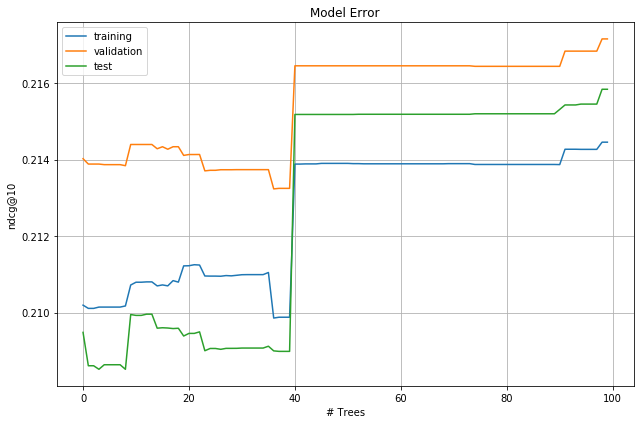

In [10]:
def evaluation(preds, train_data):
    global ds_to_queries
    #bz = eval_boltzrank(ds_to_queries[len(preds)][0], preds)
    labels = train_data.get_label()
    avg_mse = 0.5 * np.mean( (labels-preds)**2 )
    print("MSE eval: " + str(avg_mse))
    return 'MSE', avg_mse, False

def compute_grads(preds, train_data): 
    global ds_to_queries
    global train_id
    global probs_with_labels
    gain, hess = eval_boltzrank_grads(ds_to_queries[train_id][0], preds, probs_with_labels[train_id])
    gain = np.asarray(gain)
    hess = np.asarray(hess)
    print("PREDS: min " + str(np.min(preds)) + " max " + str(np.max(preds)) + " mean " + str(np.mean(preds)) + " std " + str(np.std(preds)))
    print("GAIN: min " + str(np.min(gain)) + " max " + str(np.max(gain)) + " mean " + str(np.mean(gain)) + " std " + str(np.std(gain)))
    print("HESS: min " + str(np.min(hess)) + " max " + str(np.max(hess)) + " mean " + str(np.mean(hess)) + " std " + str(np.std(hess)))
    return gain, hess

params = {
    'learning_rate': 0.1,
    'num_leaves': 16,
    'min_data_in_leaf': 5,
    'metric': ['ndcg'],# ['None']
    'ndcg_eval_at': 10
}    

print("training lightgbm...")
start = time.process_time()
lgbm_info = {}
lgbm_model = lightgbm.train(params, train_lgb, num_boost_round=100,
                            #feval = evaluation,
                            fobj  = compute_grads,
                            valid_sets   = [train_lgb, valid_lgb, test_lgb], 
                            valid_names  = ["train", "valid", "test"],
                            evals_result = lgbm_info,
                            verbose_eval = 1)
print("training took " + str(time.process_time() - start) + " s")
print("done")

# Plot the results
plt.figure(figsize=(9,6), tight_layout=True)
plt.plot(lgbm_info['train'][METRIC_NAME], label='training')
plt.plot(lgbm_info['valid'][METRIC_NAME], label='validation')
plt.plot(lgbm_info['test'][METRIC_NAME], label='test')
plt.grid()
plt.legend()
plt.xlabel("# Trees")
plt.ylabel(METRIC_NAME)
plt.title("Model Error")

In [ ]:
def check(q, k):
    indexes = set(range(0, len(q.perms)))
    indexes.remove(k)
    result = []
    for i in range(len(q.perms[k])):
        tmp = set(indexes)
        for j in tmp:
            if q.perms[k][i] != q.perms[j][i]:
                indexes.remove(j)
    for w in indexes:
        if w < k:
            result.append((w, k))
        else: 
            result.append((k,w))
    return result

def checkRepetitions():
    global queries
    same = dict()
    for q in queries.values():
        for i in range(len(q.perms)):
            r = check(q, i)
            if len(r) != 0:
                if not q.qid in same.keys():
                    same[q.qid] = set()
                for t in r:
                    same[q.qid].add(t)

    print(str(len(same.keys())) + "/" + str(len(queries.keys())) + " queries have duplicate permutations")
    for q, s in same.items():
        print("query " + str(q) + " has repeated permutations: " + str(s))
        
#checkRepetitions()            

In [ ]:
freq = {}
for query in queries.values():
    for prob in query.probs:
        if not prob in freq.keys():
            freq[prob] = 0
        freq[prob] += 1

x = []
y = []
for prob, f in sorted(freq.items()):
    x.append(prob)
    y.append(f)
    
plt.figure(figsize=(9,6), tight_layout=True)
plt.plot(x, y, '.')
plt.grid()
plt.xlabel("probability")
plt.ylabel("# rank")
plt.yscale("log")
plt.title("probabilities of the " + str(totperms) + " permutations")

In [ ]:
freq = {}
totperms = 0
for query in queries.values():
    for ndcg in query.ndcgs:
        totperms += 1
        if not ndcg in freq.keys():
            freq[ndcg] = 0
        freq[ndcg] += 1

x = []
y = []
for ndcg, f in sorted(freq.items()):
    x.append(ndcg)
    y.append(f)
    
plt.figure(figsize=(9,6), tight_layout=True)
plt.plot(x, y, '.')
plt.grid()
plt.xlabel("ndcg@10")
plt.ylabel("frequency")
plt.yscale("log")
plt.title("ndcg@10 frequencies over " + str(totperms) + " permutations")